In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
Emotions_DF = pd.read_csv('emotion.txt', delimiter=';',header=None)

In [4]:
Emotions_DF.rename(columns={0:'Sentence',1:'Emotion'},inplace=True)

In [5]:
Emotions_DF

,Sentence,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [6]:
Emotions_DF.Emotion.unique().tolist()

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

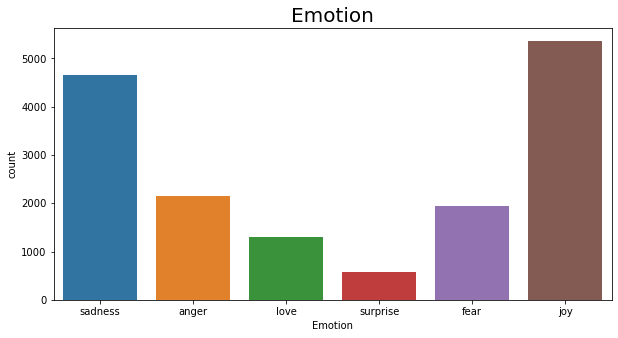

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(data = Emotions_DF, x = 'Emotion')
plt.title('Emotion',fontsize=20);

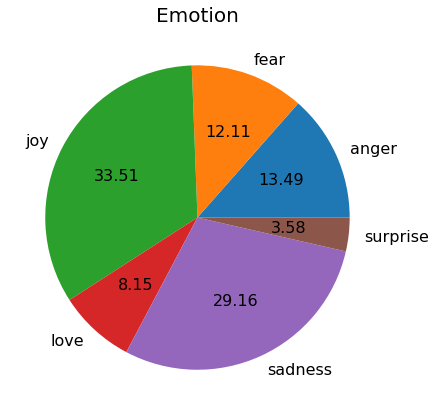

In [8]:
plt.figure(figsize=(10,7))
Emotions_DF.groupby('Emotion').size().plot.pie(autopct='%.2f', textprops={'fontsize': 16})
plt.title('Emotion',fontsize=20)
plt.ylabel('');

In [9]:
# {'joy':0.3351,'love':0.0815,'sadness':0.2916,'surprise':0.0358,'anger':0.1349,'fear':0.1211}

In [10]:
for emo in Emotions_DF.Emotion.unique():
    print('Average of sentence length of {} : {}'.format(emo, Emotions_DF.query('Emotion == "{}"'.format(emo)).Sentence.apply(lambda x :len(x)).mean()))

Average of sentence length of sadness : 92.55057865409344
Average of sentence length of anger : 96.91153311718388
Average of sentence length of love : 104.03374233128834
Average of sentence length of surprise : 101.67657342657343
Average of sentence length of fear : 96.12390294269488
Average of sentence length of joy : 98.5544572920552


In [11]:
from collections import Counter

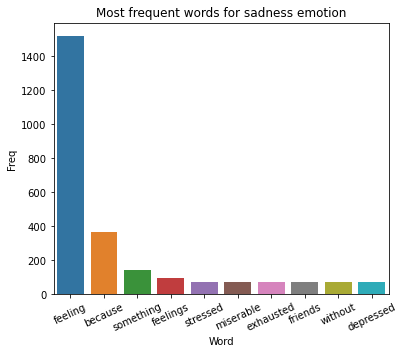

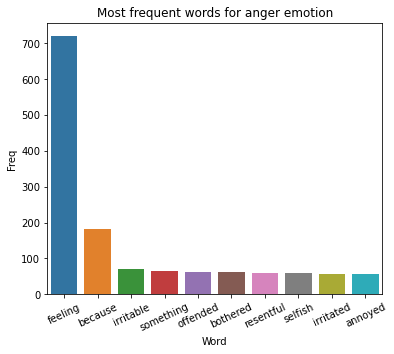

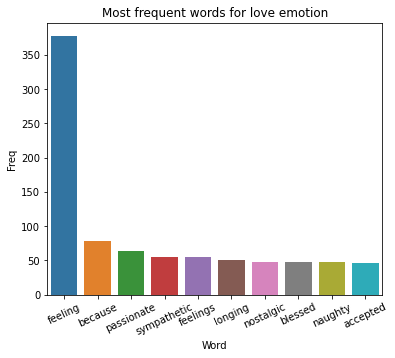

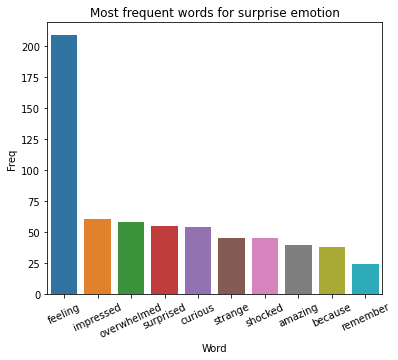

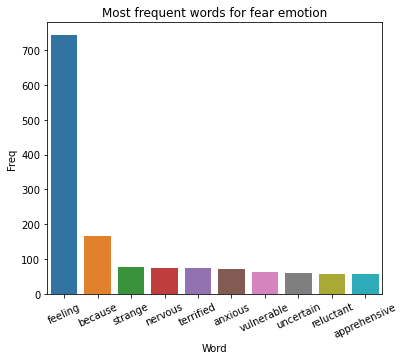

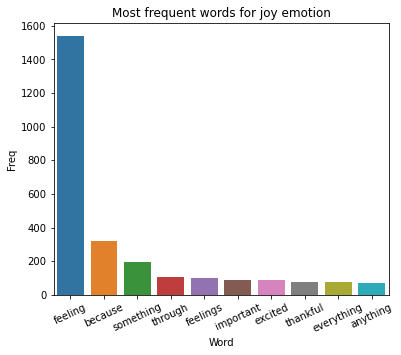

In [12]:
stops=['the','and','that','for','with','this','for','was','you','about']

for emotion in Emotions_DF.Emotion.unique():
    Data=' '.join(Emotions_DF[Emotions_DF['Emotion']==emotion]['Sentence'].values)
    tokens =[word.lower() for word in Data.split() if len(word)>6 and word.lower() not in stops ]
    dictWords=Counter(tokens).most_common(20)
    Words=[i[0] for i in dictWords]
    Freq=[i[1] for i in dictWords]
    DF=pd.DataFrame({'Word':Words,'Freq':Freq})
    plt.figure(figsize=(6,5))
    sns.barplot(x=DF['Word'][0:10],y=DF['Freq'][0:10])
    plt.title(f'Most frequent words for {emotion} emotion')
    plt.xticks(rotation=25, ha='center')
    plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(Emotions_DF['Sentence'], 
                                                    Emotions_DF['Emotion'], 
                                                    random_state=42, test_size=0.2)

In [14]:
Emotions_DF.loc[X_train.index, 'Train/Test'] = 'train'

In [15]:
Emotions_DF.loc[X_test.index, 'Train/Test'] = 'test'

In [16]:
Emotions_DF.groupby(['Emotion', 'Train/Test']).count()

Sentence
Emotion  Train/Test          
anger    test             427
         train           1732
fear     test             397
         train           1540
joy      test            1021
         train           4341
love     test             296
         train           1008
sadness  test             946
         train           3720
surprise test             113
         train            459

## Count Vectorizer

In [17]:
count_vect = CountVectorizer(ngram_range=(1,2),stop_words='english').fit(X_train)
X_train_vectorized = count_vect.transform(X_train)

In [18]:
X_train_vectorized.shape

(12800, 83089)

In [19]:
MNB = MultinomialNB(alpha=0.1)
MNB.fit(X_train_vectorized, y_train)
predictions = MNB.predict(count_vect.transform(X_test))
accuracy_score(y_test, predictions)

0.8146875

In [20]:
lsvc = LinearSVC(C=0.1)
lsvc.fit(X_train_vectorized, y_train)
predictions = lsvc.predict(count_vect.transform(X_test))
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy score: 0.9075
              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       427
        fear       0.89      0.86      0.88       397
         joy       0.90      0.95      0.92      1021
        love       0.86      0.81      0.84       296
     sadness       0.94      0.94      0.94       946
    surprise       0.86      0.75      0.80       113

    accuracy                           0.91      3200
   macro avg       0.89      0.87      0.88      3200
weighted avg       0.91      0.91      0.91      3200



In [21]:
lsvc_CM = confusion_matrix(y_test, predictions)
lsvc_CM_DF = pd.DataFrame(lsvc_CM, columns=np.unique(y_test), index = np.unique(y_test))
lsvc_CM_DF.index.name = 'Actual'
lsvc_CM_DF.columns.name = 'Predicted'

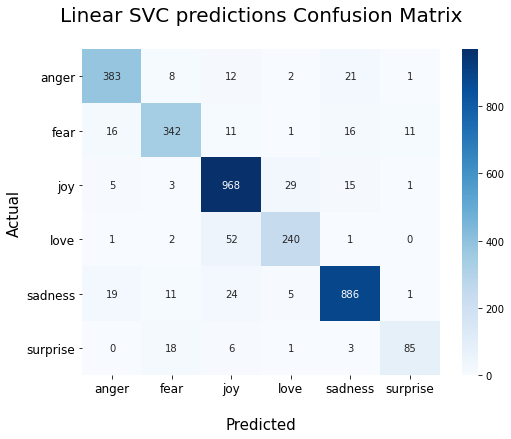

In [22]:
plt.figure(figsize=(8,6))
sns.heatmap(lsvc_CM_DF, fmt='g', annot=True, cmap='Blues')
plt.title('Linear SVC predictions Confusion Matrix\n',fontsize=20)
plt.xlabel('\nPredicted',fontsize=15)
plt.ylabel('Actual',fontsize=15)
plt.xticks(ha='center',fontsize=12)
plt.yticks(fontsize=12, rotation =0);

## Tfidf Vectorizer

In [23]:
tf_vect = TfidfVectorizer(ngram_range = (1,2),stop_words='english').fit(X_train)
X_train_vectorized = tf_vect.transform(X_train)

In [24]:
X_train_vectorized.shape

(12800, 83089)

In [25]:
MNB = MultinomialNB(alpha=0.1)
MNB.fit(X_train_vectorized, y_train)
predictions = MNB.predict(tf_vect.transform(X_test))
accuracy_score(y_test, predictions)

0.7615625

In [26]:
LR = LogisticRegression(C=100, solver='sag', class_weight='balanced', random_state=18)
LR.fit(X_train_vectorized, y_train)
predictions = LR.predict(tf_vect.transform(X_test))
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy score: 0.9034375
              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       427
        fear       0.90      0.85      0.87       397
         joy       0.92      0.92      0.92      1021
        love       0.82      0.84      0.83       296
     sadness       0.94      0.94      0.94       946
    surprise       0.75      0.82      0.78       113

    accuracy                           0.90      3200
   macro avg       0.87      0.88      0.87      3200
weighted avg       0.90      0.90      0.90      3200



In [27]:
LR_CM = confusion_matrix(y_test, predictions)
LR_CM_DF = pd.DataFrame(LR_CM, columns=np.unique(y_test), index = np.unique(y_test))
LR_CM_DF.index.name = 'Actual'
LR_CM_DF.columns.name = 'Predicted'

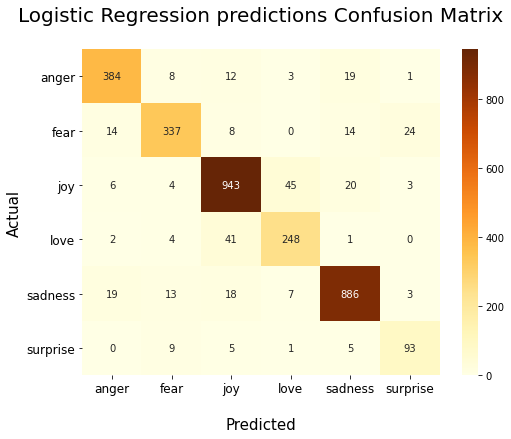

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(LR_CM_DF, fmt='g', annot=True, cmap='YlOrBr')
plt.title('Logistic Regression predictions Confusion Matrix\n',fontsize=20)
plt.xlabel('\nPredicted',fontsize=15)
plt.ylabel('Actual',fontsize=15)
plt.xticks(ha='center',fontsize=12)
plt.yticks(fontsize=12, rotation =0);

## Hashing Vectorizer

In [29]:
hash_vect = HashingVectorizer(ngram_range=(1,2) ,stop_words='english').fit(X_train)
X_train_vectorized = hash_vect.transform(X_train)

In [30]:
X_train_vectorized.shape

(12800, 1048576)

In [31]:
# MNB = MultinomialNB(alpha=0.1)
# MNB.fit(X_train_vectorized, y_train)
# predictions = MNB.predict(hash_vect.transform(X_test))
# accuracy_score(y_test, predictions)

In [32]:
LR = LogisticRegression(C=100, solver='sag', class_weight='balanced', random_state=18)
LR.fit(X_train_vectorized, y_train)
predictions = LR.predict(hash_vect.transform(X_test))
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy score: 0.9
              precision    recall  f1-score   support

       anger       0.89      0.90      0.89       427
        fear       0.89      0.83      0.86       397
         joy       0.90      0.94      0.92      1021
        love       0.83      0.82      0.83       296
     sadness       0.94      0.93      0.93       946
    surprise       0.78      0.79      0.78       113

    accuracy                           0.90      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.90      0.90      0.90      3200



In [33]:
LR_CM = confusion_matrix(y_test, predictions)
LR_CM_DF = pd.DataFrame(LR_CM, columns=np.unique(y_test), index = np.unique(y_test))
LR_CM_DF.index.name = 'Actual'
LR_CM_DF.columns.name = 'Predicted'

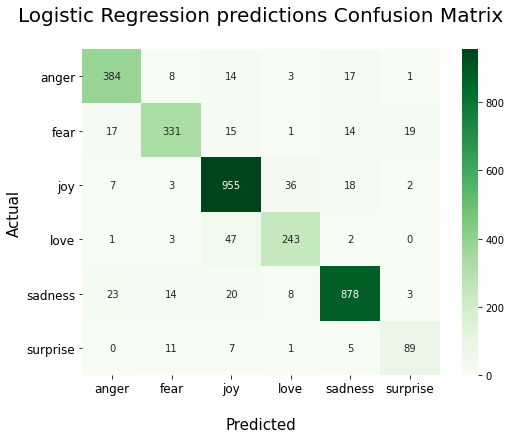

In [34]:
plt.figure(figsize=(8,6))
sns.heatmap(LR_CM_DF, fmt='g', annot=True, cmap='Greens')
plt.title('Logistic Regression predictions Confusion Matrix\n',fontsize=20)
plt.xlabel('\nPredicted',fontsize=15)
plt.ylabel('Actual',fontsize=15)
plt.xticks(ha='center',fontsize=12)
plt.yticks(fontsize=12, rotation =0);

In [35]:
lsvc = LinearSVC(C=10, random_state=18)
lsvc.fit(X_train_vectorized, y_train)
predictions = lsvc.predict(hash_vect.transform(X_test))
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy score: 0.9015625
              precision    recall  f1-score   support

       anger       0.90      0.89      0.90       427
        fear       0.88      0.86      0.87       397
         joy       0.89      0.95      0.92      1021
        love       0.86      0.77      0.82       296
     sadness       0.94      0.93      0.94       946
    surprise       0.84      0.73      0.78       113

    accuracy                           0.90      3200
   macro avg       0.89      0.86      0.87      3200
weighted avg       0.90      0.90      0.90      3200



In [36]:
lsvc_CM = confusion_matrix(y_test, predictions)
lsvc_CM_DF = pd.DataFrame(lsvc_CM, columns=np.unique(y_test), index = np.unique(y_test))
lsvc_CM_DF.index.name = 'Actual'
lsvc_CM_DF.columns.name = 'Predicted'

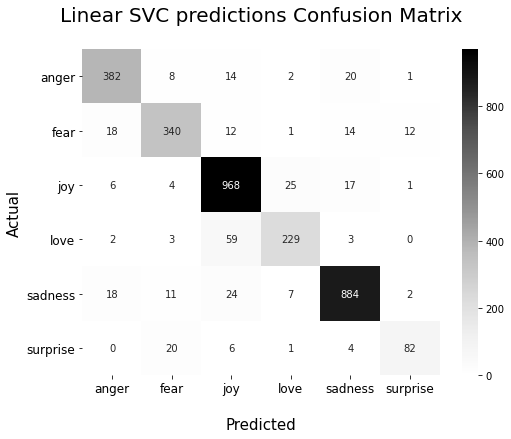

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(lsvc_CM_DF, fmt='g', annot=True, cmap='Greys')
plt.title('Linear SVC predictions Confusion Matrix\n',fontsize=20)
plt.xlabel('\nPredicted',fontsize=15)
plt.ylabel('Actual',fontsize=15)
plt.xticks(ha='center',fontsize=12)
plt.yticks(fontsize=12, rotation =0);

In [38]:
model = Sequential()
model.add(Dense(8, input_dim=1048576, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train_vectorized, pd.get_dummies(y_train),  epochs=10, verbose=1, batch_size=400)

Epoch 1/10
 1200/12800 [=>............................] - ETA: 14:08 - loss: 0.4504 - accuracy: 0.8333

In [ ]:
plt.plot(model.history.epoch, model.history.history['loss'])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('loss', fontsize=14);

In [ ]:
plt.plot(model.history.epoch, model.history.history['accuracy'])
plt.xlabel('epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14);

In [ ]:
model.evaluate(hash_vect.transform(X_test), pd.get_dummies(y_test))